In [19]:
import torch 
import torch.nn as nn
import os
import time
import importlib
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np 
import random
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

import torchvision.transforms as transforms
import torchvision

MAIN REPVGG Apart from main architecture specification I have also included  Reparameterization


In [20]:
class block(nn.Module):

    def __init__(self,in_channels=None,out_channels=None):
        super(block,self).__init__()
        self.in_channels = in_channels 
        self.out_channels = out_channels
        self.nl = nn.ReLU()
        self.s = nn.Identity()
        b1 = [nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels,
                                                  kernel_size=(3,3), stride=(2,2), padding=(1,1)),nn.BatchNorm2d(num_features=self.out_channels)]
        self.x = nn.Sequential(*b1)
        b2 = [nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels,
                                                  kernel_size=(1,1), stride=(2,2), padding=(0,0)),nn.BatchNorm2d(num_features=self.out_channels)]
        self.y = nn.Sequential(*b2)
    def forward(self,input):
        out = self.x(input) + self.y(input) 
        out = self.s(out)
        out = self.nl(out)
        return out 


class REPVGG(nn.Module):
   def __init__(self,in_channels=3,num_classes=10,blocks=None,multipl=None):
    super(REPVGG,self).__init__()
    self.blocks= blocks
    self.multipl= multipl 
    self.in_channels = in_channels
    self.main_REPVGG = self.main_architecture()
    self.g = nn.AdaptiveAvgPool2d(output_size=1)
    self.linear = nn.Linear(int(512 * multipl[3]), num_classes)                               
   
   def main_architecture(self):
            layers = []


            #stage0

            
            multipl = self.multipl
            out_channels = min(64,int(64*multipl[0])) 
            in_channels = self.in_channels
            blocks = self.blocks
            layers += [block(in_channels = in_channels,out_channels=out_channels)]
            in_channels = min(64, int(64*multipl[0]))




            #stage1,stage2,stage3,stage4



            for i in range(4):

              out_channels = int(64*(2**i) * multipl[i])
              layers += [block(in_channels = in_channels,out_channels=out_channels)]
              in_channels = out_channels

              for j in range(blocks[i]-1):
                layers += [block(in_channels = in_channels,out_channels=out_channels)]
              in_channels = out_channels 

            return nn.Sequential(*layers)

   def forward(self,x):
     x = self.main_REPVGG(x)
     x = self.g(x)
     x = x.view(x.size(0), -1)
     x = self.linear(x)
     return x

In [21]:
transform = transforms.Compose([transforms.Pad(4),transforms.RandomHorizontalFlip(),transforms.RandomCrop(32),transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
test_transform  = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='../../data/', train=True,transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='../../data/', train=False,transform=test_transform)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=100, shuffle=False)

Files already downloaded and verified


### **DIFFERENT TYPES OF REPVGG I have only implemented A1 BECAUSE IT IS SMALLEST but it is recommended to use B2 architecture since according to paper it giver best top1 accuracy all other can be implemented just by changing the arguments  **

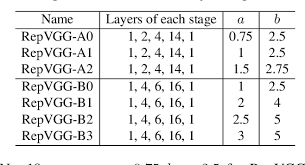

In [22]:
depth = 2
epochs = 80
batch_size = 256
base_lr = 0.01
lr_decay = 0.0001
milestones = '[80, 120]'
device = "cuda"
num_workers = 3

model = REPVGG(in_channels=3,num_classes=10,blocks=[2, 4, 14, 1],multipl=[0.75, 0.75, 0.75, 2.5]).to(device)
#model = VGG(in_channels = 3, num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=lr_decay)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=lr_decay)
flag = 0 
for epoch in range(epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 500 == 0:
      print ("Epoch {}, Step {} Loss: {:.4f}".format(epoch+1, i+1, loss.item()))
    if loss.item() < 0.1 :
      break 
      flag =1
  if flag == 1:
    break 
 # scheduler.step()

Epoch 1, Step 500 Loss: 2.1702
Epoch 2, Step 500 Loss: 1.8880
Epoch 3, Step 500 Loss: 1.8992
Epoch 4, Step 500 Loss: 1.9222
Epoch 5, Step 500 Loss: 1.7223
Epoch 6, Step 500 Loss: 1.7283
Epoch 7, Step 500 Loss: 1.6725
Epoch 8, Step 500 Loss: 1.5629
Epoch 9, Step 500 Loss: 1.6171
Epoch 10, Step 500 Loss: 1.5002
Epoch 11, Step 500 Loss: 1.2740
Epoch 12, Step 500 Loss: 1.4089
Epoch 13, Step 500 Loss: 1.2138
Epoch 14, Step 500 Loss: 1.3098
Epoch 15, Step 500 Loss: 1.0114
Epoch 16, Step 500 Loss: 1.1923
Epoch 17, Step 500 Loss: 1.1322
Epoch 18, Step 500 Loss: 1.0321
Epoch 19, Step 500 Loss: 1.0812
Epoch 20, Step 500 Loss: 1.1009
Epoch 21, Step 500 Loss: 0.8372
Epoch 22, Step 500 Loss: 1.1218
Epoch 23, Step 500 Loss: 0.9343
Epoch 24, Step 500 Loss: 0.9614
Epoch 25, Step 500 Loss: 0.8275
Epoch 26, Step 500 Loss: 0.9798
Epoch 27, Step 500 Loss: 1.0733
Epoch 28, Step 500 Loss: 0.9817
Epoch 29, Step 500 Loss: 0.8376
Epoch 30, Step 500 Loss: 0.7596
Epoch 31, Step 500 Loss: 0.8261
Epoch 32, Step 50

In [23]:
 model.eval

<bound method Module.eval of REPVGG(
  (main_REPVGG): Sequential(
    (0): block(
      (nl): ReLU()
      (s): Identity()
      (x): Sequential(
        (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (y): Sequential(
        (0): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): block(
      (nl): ReLU()
      (s): Identity()
      (x): Sequential(
        (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (y): Sequential(
        (0): Conv2d(48, 48, kernel_size=(1, 1), stride=(2, 2))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): block(
      (nl): Re

In [25]:
model.eval()
with torch.no_grad():
    total = 0
    correct =0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy ( test images ) : {} %'.format(100 * correct / total))

Accuracy ( test images ) : 81.046 %
